In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cycler
import warnings
warnings.filterwarnings('ignore')


In [2]:
#plantilla para ver los graficos en negro

import matplotlib as mpl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988dd',
                '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor='#313233', edgecolor ='none',
        axisbelow=True, grid=True, prop_cycle=colors,
        labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor='#313233', edgecolor='#313233')
plt.rc('text', color='#C9C9C9')
plt.rc('figure', facecolor='#313233')


Section 1: Sortino 
Sortino
El indice sortino es una estrategia similat a indice de sharpe con las misma interpretacion. Sin embargo el calculo es diferente.
En efecto en el indice sortino solo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tenemos y no las ganancias alcistas que nos hacen ganar dinero.

Sortino <0  Inversio no rentable por que las ganancias son negativas 
Sortino <1 inversion rentable pero el riesgo de la incersion es mayor que la rentabilidad
Sortino > 1: Inversion muy rentable porque el riresgo es menor que el rendimiento 




In [3]:
#preparar los datos 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"]. pct_change(1).dropna()
return_serie.name = "return"

#calcular el indice desortino
mean = np.mean(return_serie) #252 de los dias que esta habierto el mercado 
vol = np.std(return_serie[return_serie>0])   # sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")


[*********************100%%**********************]  1 of 1 completed

Sortino: 1.093


Beta 
la beta es un estadistico que indica la relacion entre las variaciones de nuestra cartera y las del mercado que esta representado por un indice varia en 1 

Section 2: Drowndown

El drawdown es uan medida del riesgo de la estrategia. Una estrategia interesante para conocer el rendimiento del algotitmo es el 
drawdown maximo.En efecto representa la perdida de una estrategia durante un periodo de tiempo que le permite comprender si la estrategia es arriesgada y por lo tanto elegirla en funcion de nuestro nivel de aversion al riesgo.


In [4]:
def drawdown_function(serie):
    
    #calcular la suma de los rendimientos 
    cum = serie.dropna().cumsum() +1

    #calcular el maximo de la sima en el periodo (maximo acumulado ) # (1,3,5,3,1) --> (1,3,5,5,5)
    runnig_max = np.maximum.accumulate(cum)

    #calcular el drawdown
    drawdown = cum/runnig_max -1
    
    return drawdown

In [5]:
drawdown = drawdown_function(return_serie)
drawdown

Date
2004-08-20    0.000000
2004-08-23    0.000000
2004-08-24   -0.038006
2004-08-25   -0.028116
2004-08-26   -0.011578
                ...   
2020-12-24   -0.009246
2020-12-28   -0.005249
2020-12-29   -0.007074
2020-12-30   -0.009112
2020-12-31   -0.007786
Name: return, Length: 4121, dtype: float64

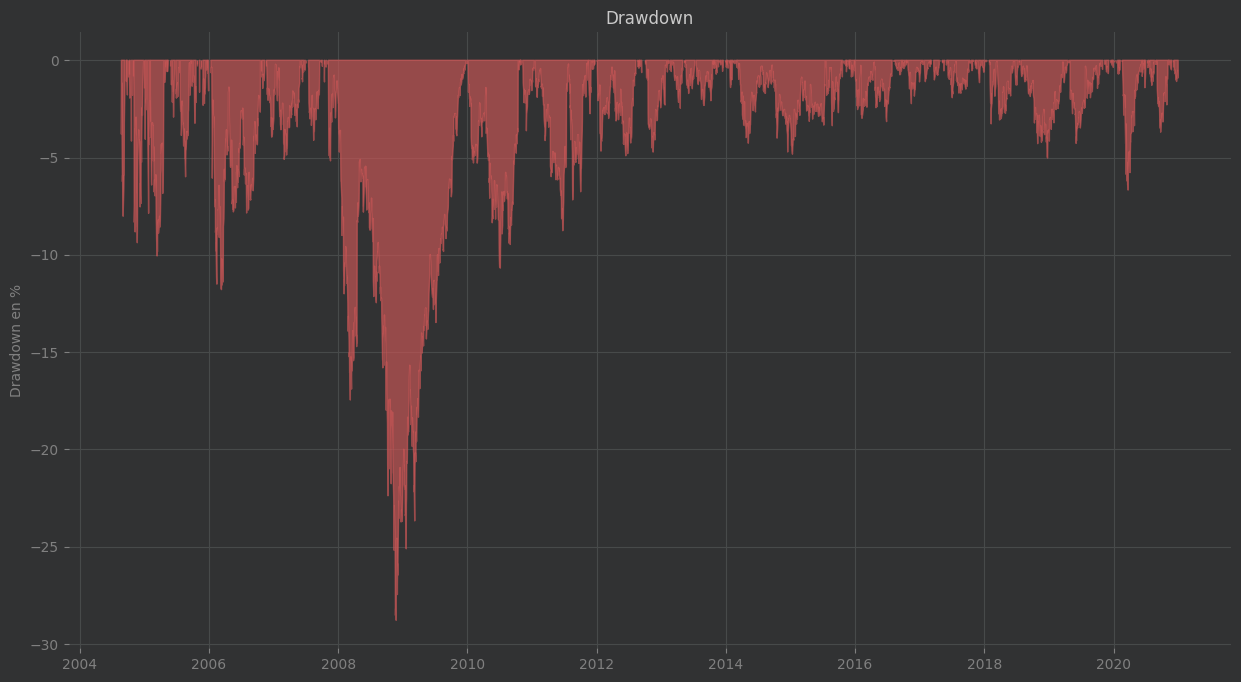

In [6]:
#adaptar el tamaño de la figura 
plt.figure(figsize=(15,8))

#representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

#añadir el titulo 
plt.title("Drawdown")

#Etiqueta del eje de la Y
plt.ylabel("Drawdown en %")

plt.show()





Secction 3 Crear la funcion BackTest para evaluar la estrategia en las secciones posteriores 

In [18]:
def BackTest(serie, annualiazed_scalar=252):

    #Importar el benchmark 
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)

    #cambiar el nombre 
    sp500.name = "SP500"

    #concatenar los retornos y el sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

    #calcular el dropdown
    drawdown = drawdown_function(serie)*100

    #calcular el max drawndown
    max_drawdown =-np.min(drawdown)

    #put a subplots 
    fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))

    #put a suplite
    fig.suptitle("Backtestig", size=20)

    #return cumdum chart
    cum.plot(serie.cumsum()*100, color = "#39B3C7")

    #sp500 cumsum chart
    cum.legend(["Portfolio", "SP500"])
    
    #set individua title
    cum.set_title("Cumulative Return", size =13)

    cum.set_ylabel("Cumulative % ", size =11)

    #put the drawdown
    dra.fill_between(drawdown.index, 0, drawdown, color = "#C73954", alpha =0.65)
    
    #set individual title

    dra.set_title("Drawdown", size =13)

    dra.set_ylabel("drawdown en %", size =11)

    #plot the graph
    plt.show()

    #calcular el indice de sortino
    sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

    #calcular el indice beta 
    beta = np.cov(val[["return", "SP500"]].values,rowvar= False)[0][1] / np.var(val["SP500"].values)

    #calciular el indice de alpha

    alpha = annualiazed_scalar * (serie.mean() - beta *serie.mean())

    #imprimir los estadisticos 
    print(f"Sortino: {np.round(sortino,3)}" )
    print(f"Beta: {np.round(beta,3)}" )
    print(f"Alpha: {np.round(alpha*100,3)}%" )
    print(f"MaxDrawdown: {np.round(max_drawdown,3)}%" )
    





[*********************100%%**********************]  1 of 1 completed


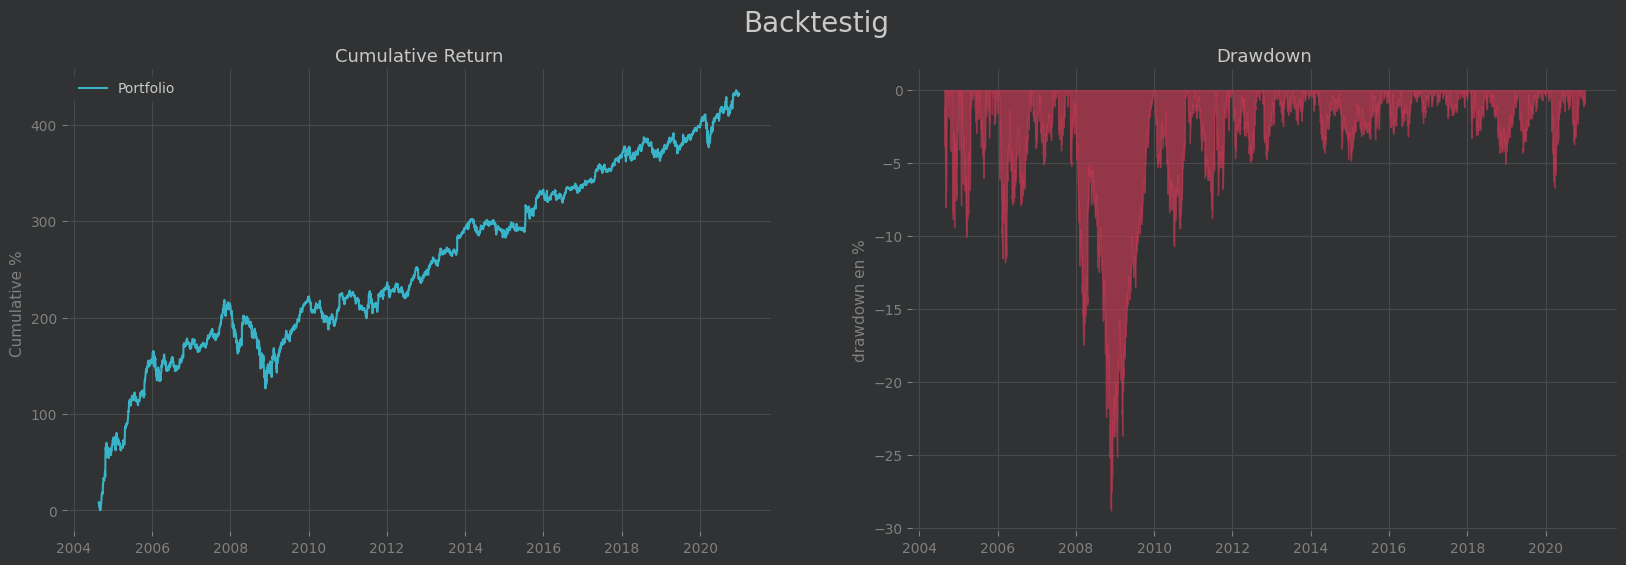

Sortino: 1.232
Beta: 0.965
Alpha: 0.918%
MaxDrawdown: 28.78%


In [19]:
BackTest(return_serie, annualiazed_scalar=252)

In [ ]:
###APLICATION
#pip install ta

In [ ]:
def SMA_strategy(input, mt5=False, yf = False):

    if mt5:
        df = preprocessing(input)

    if yf:
        df = preprocessing_yf(input)

    #crear resistance using a rolling max
    df["SMA fast"] = df['close'].rolling(30).mean()

    #create suport usinf a rolling min

    df["SMA slow"] = df["close"].rolling().mean()
    